In [42]:
import datetime
import logging
import os
import numpy as np
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner,
)
import matplotlib.pyplot as plt
## Only when developing with VSCode in my repo 
#os.chdir('/home/nicolas/codeRepo/OceanPlatformControl') # here in Azure
os.chdir('/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl') # here in WSL
print(os.getcwd())
##
import pandas as pd
from ocean_navigation_simulator.utils.units import Distance
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define Filenames

In [2]:
path_to_files = 'generated_media/metrics_csv_results/'
file_containing_pb = 'problemsGOM.csv'
pb_name_hj_naive = 'problemsGOMmetrics_hj_naive.csv'
pb_name_reactive = 'problemsGOMmetrics_reactive.csv'
pb_name_flocking = 'problemsGOMmetrics_flocking.csv'

### Plot problem distribution

In [44]:
# TODO

### Extract metrics from csv files

In [57]:
metrics_hj_naive = pd.read_csv(f"{path_to_files}/{pb_name_hj_naive}")
metrics_hj_reactive = pd.read_csv(f"{path_to_files}/{pb_name_reactive}")
metrics_hj_flocking = pd.read_csv(f"{path_to_files}/{pb_name_flocking}")

In [45]:
metrics_hj_naive

,Isolated_platform_metric,Number_of_collision,Reaching_target,Mean minimum distance to target among all platforms in deg,Mean maximum correction from optimal control degrees,Average Beta Index,Initial maximum degree of the graph,Final maximum degree of the graph,Mission_sucess
0,0,0,1.00,0.000000,0,1.242545,2,3,1
1,0,0,0.00,0.073967,0,1.104537,2,3,0
2,45800,0,1.00,0.000000,0,1.010638,2,3,0
3,0,0,1.00,0.000000,0,1.252546,2,3,1
4,0,0,1.00,0.000000,0,1.385510,3,3,1
5,259500,0,1.00,0.000000,0,0.812057,2,3,0
6,0,1,1.00,0.000000,0,1.333178,3,3,0
7,175200,0,1.00,0.000000,0,0.762559,2,3,0
8,130200,0,0.25,0.021353,0,0.849909,2,3,0
9,0,0,1.00,0.000000,0,1.500000,3,3,1


### Get Metrics summary as a dict:

In [50]:
def get_metrics_summary(metrics_file:pd.DataFrame)->dict:
    return {
    "avg_beta_index":np.mean(metrics_file["Average Beta Index"]),
    "avg_isolated_pltf_integral_hj_naive": np.mean(metrics_file["Isolated_platform_metric"]),
    "avg_correction_from_opt_ctrl_deg": np.mean(metrics_file["Mean maximum correction from optimal control degrees"]),
    "avg_mean_min_dist_to_target_km": Distance(deg=np.mean(metrics_file["Mean minimum distance to target among all platforms in deg"])).km,
    "avg_nb_platfroms_reaching_target": np.mean(metrics_file["Reaching_target"]),
    "nb_missions_with_isolated_pltf": np.sum(metrics_file["Isolated_platform_metric"] > 0),
    "nb_missions_with_collisions": np.sum(metrics_file["Number_of_collision"] > 0),
    "nb_missions_success": np.sum(metrics_file["Mission_sucess"]==1),
}

  + HJ Multi-Agent Naive

In [55]:
metrics_summary_hj_naive = get_metrics_summary(metrics_hj_naive)
print(metrics_summary_hj_naive)

{'avg_beta_index': 1.061275035767803, 'avg_isolated_pltf_integral_hj_naive': 97363.33333333333, 'avg_correction_from_opt_ctrl_deg': 0.0, 'avg_mean_min_dist_to_target_km': 0.6022088646782777, 'avg_nb_platfroms_reaching_target': 0.825, 'nb_missions_with_isolated_pltf': 13, 'nb_missions_with_collisions': 3, 'nb_missions_success': 12}


+ HJ Multi-Agent Decentralized Reactive Control

In [58]:
metrics_summary_hj_reactive = get_metrics_summary(metrics_hj_reactive)
print(metrics_summary_hj_reactive)

{'avg_beta_index': 1.186604837912937, 'avg_isolated_pltf_integral_hj_naive': 40456.666666666664, 'avg_correction_from_opt_ctrl_deg': 18.377194396733806, 'avg_mean_min_dist_to_target_km': 0.8437515136827586, 'avg_nb_platfroms_reaching_target': 0.7916666666666666, 'nb_missions_with_isolated_pltf': 11, 'nb_missions_with_collisions': 0, 'nb_missions_success': 13}


+ HJ Multi-Agent Flocking

In [59]:
metrics_summary_hj_flocking = get_metrics_summary(metrics_hj_flocking)
print(metrics_summary_hj_flocking)

{'avg_beta_index': 1.3732038733493388, 'avg_isolated_pltf_integral_hj_naive': 4186.666666666667, 'avg_correction_from_opt_ctrl_deg': 24.322445525956223, 'avg_mean_min_dist_to_target_km': 0.6979519567421218, 'avg_nb_platfroms_reaching_target': 0.7916666666666666, 'nb_missions_with_isolated_pltf': 3, 'nb_missions_with_collisions': 0, 'nb_missions_success': 18}


### Plots

In [65]:
def plot_confusion_matrix(x, y, x_label, y_label, title_name:str):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    confusion_matrix = pd.crosstab(x, y, rownames=[x_label], colnames=[y_label])

    ax = sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.RdYlGn, square=True, norm=LogNorm(), fmt='g')
    plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=True, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.plot
    plt.title(title_name)
    plt.show()

###  HJ naive vs Decentralized Reactive Control

+  Missions success counts

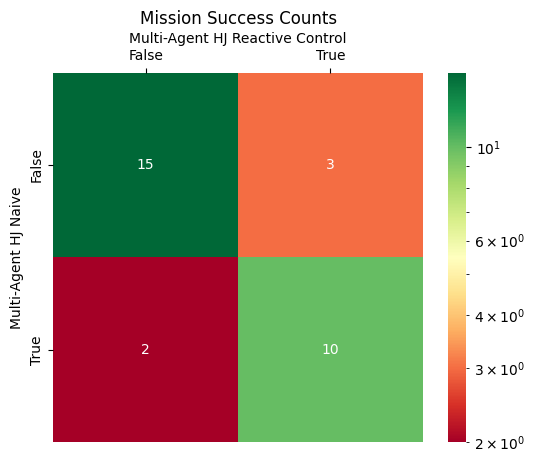

In [71]:
plot_confusion_matrix(metrics_hj_naive["Mission_sucess"]==1, 
                        metrics_hj_reactive["Mission_sucess"]==1, 'Multi-Agent HJ Naive', 
                        'Multi-Agent HJ Reactive Control', title_name="Mission Success Counts")

+ Connectivity and Collision maintenance performance

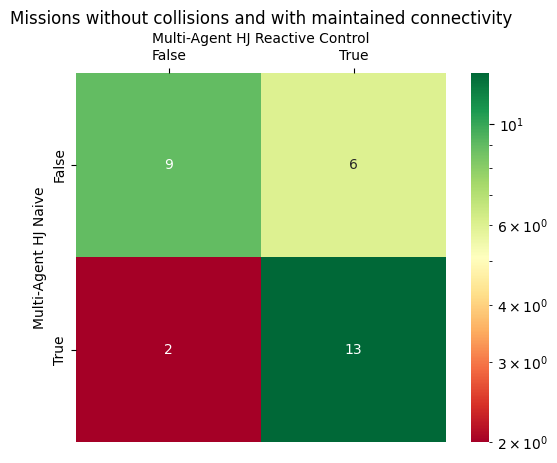

In [72]:
connect_objective_reactive = (metrics_hj_reactive["Isolated_platform_metric"]==0) & (metrics_hj_reactive["Number_of_collision"] == 0)
connect_objective_hj_naive = (metrics_hj_naive["Isolated_platform_metric"]==0) & (metrics_hj_naive["Number_of_collision"] == 0)
plot_confusion_matrix(connect_objective_hj_naive , connect_objective_reactive , 
    'Multi-Agent HJ Naive', 'Multi-Agent HJ Reactive Control', title_name= 'Missions without collisions and with maintained connectivity')

###  HJ naive vs Flocking

+  Missions success counts

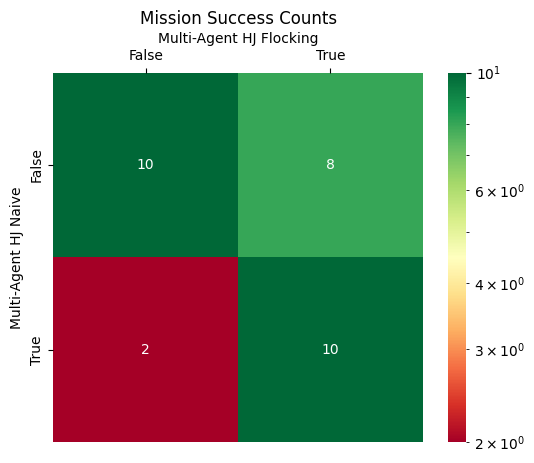

In [68]:
plot_confusion_matrix(metrics_hj_naive["Mission_sucess"]==1, 
                        metrics_hj_flocking["Mission_sucess"]==1, 'Multi-Agent HJ Naive', 
                        'Multi-Agent HJ Flocking', title_name="Mission Success Counts")

+ Connectivity and Collision maintenance performance

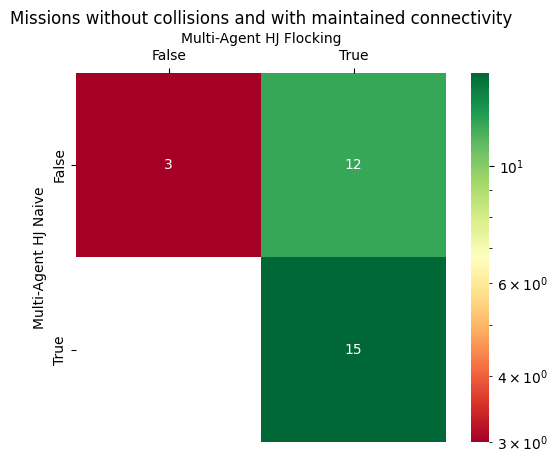

In [69]:
connect_objective_flocking = (metrics_hj_flocking["Isolated_platform_metric"]==0) & (metrics_hj_flocking["Number_of_collision"] == 0)
connect_objective_hj_naive = (metrics_hj_naive["Isolated_platform_metric"]==0) & (metrics_hj_naive["Number_of_collision"] == 0)
plot_confusion_matrix(connect_objective_hj_naive , connect_objective_flocking , 
    'Multi-Agent HJ Naive', 'Multi-Agent HJ Flocking', title_name= 'Missions without collisions and with maintained connectivity')